<a href="https://colab.research.google.com/github/Harshi782/Harahirtha/blob/main/DMNetmodel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install the latest versions of TensorFlow and Keras
# This might resolve compatibility issues.
# You might need to restart your runtime after running this cell.
!pip install --upgrade tensorflow keras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.7/620.7 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 72.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 117.2 MB/s eta 0:00:00
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.19.0
    Uninstalling tensorboard-2.19.0:
      Successfully uninstalled tensorboard-2.19.0
  Attempting uninstall: keras
    Found existing installation: keras 3.10.0
    Uninstalling keras-3.10.0:
      Successfully uninstalled keras-3.10.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.19.0
    Uninstalling tensorflow-2.19.0:
      Successfully uninstalled tensorflow-2.19.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.12.0 requires tensorflow==2.19.0, but you have tensorflow 2.20.

In [ ]:
# Try installing specific versions of tensorflow and keras that might be compatible
# This might resolve the AttributeError related to internal TensorFlow functions
# You might need to restart your runtime after running this cell.
!pip install tensorflow==2.10.0 keras==2.10.0

ERROR: Could not find a version that satisfies the requirement tensorflow==2.10.0 (from versions: 2.16.0rc0, 2.16.1, 2.16.2, 2.17.0rc0, 2.17.0rc1, 2.17.0, 2.17.1, 2.18.0rc0, 2.18.0rc1, 2.18.0rc2, 2.18.0, 2.18.1, 2.19.0rc0, 2.19.0, 2.19.1, 2.20.0rc0, 2.20.0)
ERROR: No matching distribution found for tensorflow==2.10.0


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pandas as pd # Import pandas

# Reload the DataFrame to ensure all steps are run sequentially
df = pd.read_csv('dmnet_synthetic_10000.csv')

# --- 1. Select Features and Target ---
# We'll use a mix of numerical and one-hot encoded categorical features
numerical_features = ['age_at_visit', 'systolic_bp', 'diastolic_bp', 'height_cm', 'weight_kg', 'bmi',
                      'hba1c', 'fasting_glucose_mg_dl', 'ldl_mg_dl']
categorical_features = ['sex', 'smoking_status', 'alcohol_use']
target_column = 'diabetes_active'
sequence_id_column = 'patient_id'

# --- 2. Handle Missing Data (Simple Imputation) ---
# Fill missing diagnosis codes (which are categorical) with 'Unknown'
df['diagnosis_codes'] = df['diagnosis_codes'].fillna('Unknown')
df['primary_diagnosis'] = df['primary_diagnosis'].fillna('Unknown')
df['medications'] = df['medications'].fillna('None')

# --- 3. Feature Engineering and Scaling ---
# One-hot encode categorical features (sex, smoking, alcohol use)
df = pd.get_dummies(df, columns=categorical_features, drop_first=True)
feature_columns = numerical_features + [col for col in df.columns if any(cat in col for cat in categorical_features)]

# Scale numerical features
scaler = MinMaxScaler()
df[numerical_features] = scaler.fit_transform(df[numerical_features])


# --- 4. Create Time-Series Sequences (The DMNet Input) ---

# Dictionary to store sequences: {patient_id: list_of_visits}
patient_sequences = {}
patient_targets = {}

for patient_id, group in df.groupby(sequence_id_column):
    # Sort visits by date to ensure proper sequence order
    group = group.sort_values('visit_date')

    # Extract features for the sequence
    sequence = group[feature_columns].values

    # The target is the final outcome of the sequence (e.g., whether the patient has diabetes now)
    target = group[target_column].iloc[-1]

    patient_sequences[patient_id] = sequence
    patient_targets[patient_id] = target

# --- 5. Pad Sequences for Fixed Input Length ---
# Convert dictionary values to lists
X_list = list(patient_sequences.values())
Y = np.array(list(patient_targets.values()))

# Pad sequences to a fixed length (e.g., 20 visits). Shorter sequences are padded with zeros.
MAX_SEQUENCE_LENGTH = 20
X_padded = pad_sequences(X_list, maxlen=MAX_SEQUENCE_LENGTH, dtype='float32', padding='post', truncating='post')

print(f"Total sequences (patients): {len(X_padded)}")
print(f"Sequence shape (Visits, Features): {X_padded.shape}")
print(f"Padded data successfully created for DMNet.")

Total sequences (patients): 10000
Sequence shape (Visits, Features): (10000, 20, 15)
Padded data successfully created for DMNet.


In [ ]:
# Split the padded data (X_padded) and the targets (Y)
X_train, X_test, Y_train, Y_test = train_test_split(
    X_padded,
    Y,
    test_size=0.2,
    random_state=42,
    stratify=Y # Ensure the proportion of diabetes/non-diabetes patients is preserved
)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"Y_train shape: {Y_train.shape}")
print(f"Y_test shape: {Y_test.shape}")

X_train shape: (8000, 20, 15)
X_test shape: (2000, 20, 15)
Y_train shape: (8000,)
Y_test shape: (2000,)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Masking
from tensorflow.keras.optimizers import Adam

# Parameters from the padded data
SEQUENCE_LENGTH = X_train.shape[1]  # 20
FEATURE_COUNT = X_train.shape[2]    # Number of features after one-hot encoding

# DMNet Model Definition
dmnet_model = Sequential([
    # Masking layer ignores padded (zero) values, preventing the LSTM from learning noise.
    Masking(mask_value=0., input_shape=(SEQUENCE_LENGTH, FEATURE_COUNT)),

    # LSTM layer for learning temporal dependencies in patient visits
    LSTM(units=64, return_sequences=False),

    # Dropout layer for regularization (preventing overfitting)
    Dropout(0.3),

    # Output layer for binary classification (Diabetes Active: 0 or 1)
    Dense(units=1, activation='sigmoid')
])

# Compile the model
dmnet_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy', # Appropriate for binary classification
    metrics=['accuracy', 'Precision', 'Recall']
)

dmnet_model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/masking.py:48: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking (Masking)               │ (None, 20, 15)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        20,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,545 (80.25 KB)

 Trainable params: 20,545 (80.25 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the model
history = dmnet_model.fit(
    X_train,
    Y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.1, # Use 10% of training data for validation
    verbose=1
)

Epoch 1/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - Precision: 0.9296 - Recall: 0.6022 - accuracy: 0.8933 - loss: 0.2890 - val_Precision: 1.0000 - val_Recall: 0.8229 - val_accuracy: 0.9575 - val_loss: 0.1686
Epoch 2/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - Precision: 0.9941 - Recall: 0.8805 - accuracy: 0.9700 - loss: 0.1119 - val_Precision: 1.0000 - val_Recall: 0.8698 - val_accuracy: 0.9688 - val_loss: 0.1100
Epoch 3/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - Precision: 1.0000 - Recall: 0.9226 - accuracy: 0.9814 - loss: 0.0727 - val_Precision: 1.0000 - val_Recall: 0.9167 - val_accuracy: 0.9800 - val_loss: 0.0705
Epoch 4/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - Precision: 0.9994 - Recall: 0.9452 - accuracy: 0.9867 - loss: 0.0553 - val_Precision: 1.0000 - val_Recall: 0.9271 - val_accuracy: 0.9825 - val_loss: 0.0592
Epoch 5/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - Precision: 1.0000 - Recall: 0.9503 - accuracy: 0.9881 - loss: 0.0471 - val_Precision: 1.0000 - val_Recall

--- DMNet Test Results ---
Test Loss: 0.0221
Test Accuracy: 0.9950
Test Precision: 1.0000
Test Recall: 0.9792
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

--- Classification Report ---
                     precision    recall  f1-score   support

    No Diabetes (0)       0.99      1.00      1.00      1519
Diabetes Active (1)       1.00      0.98      0.99       481

           accuracy                           0.99      2000
          macro avg       1.00      0.99      0.99      2000
       weighted avg       1.00      0.99      0.99      2000



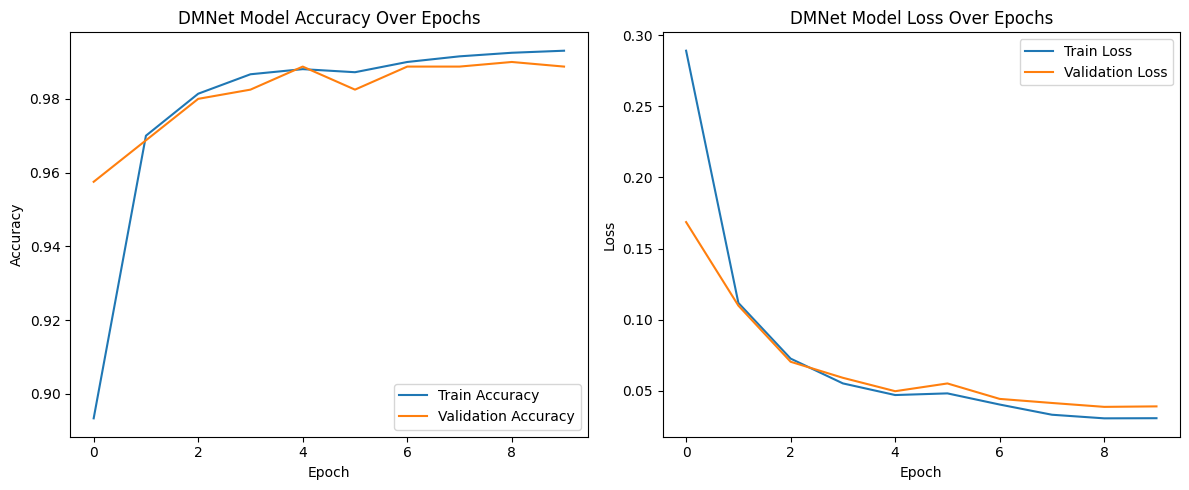

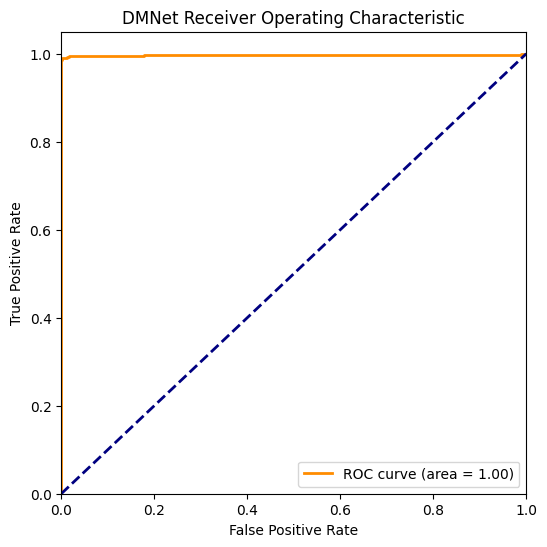

DMNet code is complete. Review the results and plots in your Colab output!


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_curve, auc

# --- 1. Evaluate on Test Data ---
loss, accuracy, precision, recall = dmnet_model.evaluate(X_test, Y_test, verbose=0)

print(f"--- DMNet Test Results ---")
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")

# --- 2. Classification Report ---
Y_pred_proba = dmnet_model.predict(X_test)
Y_pred = (Y_pred_proba > 0.5).astype(int)

print("\n--- Classification Report ---")
print(classification_report(Y_test, Y_pred, target_names=['No Diabetes (0)', 'Diabetes Active (1)']))


# --- 3. Plot Training History ---
plt.figure(figsize=(12, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('DMNet Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('DMNet Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.savefig('dmnet_training_history.png')
plt.show()

# --- 4. Plot ROC Curve ---
fpr, tpr, thresholds = roc_curve(Y_test, Y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('DMNet Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig('dmnet_roc_curve.png')
plt.show()

print("DMNet code is complete. Review the results and plots in your Colab output!")

In [ ]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten

# Hybrid DMNet Model Definition
hybrid_dmnet_model = Sequential([
    # 1. Masking Layer
    Masking(mask_value=0., input_shape=(SEQUENCE_LENGTH, FEATURE_COUNT)),

    # 2. CNN Layers (Feature Extraction)
    # Conv1D searches for local patterns (e.g., changes over 3 consecutive visits)
    Conv1D(filters=32, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),

    # 3. LSTM Layer (Temporal Learning)
    # The output of the CNN is fed to the LSTM for sequence memory
    LSTM(units=64, return_sequences=False),

    # 4. Final Layers
    Dropout(0.3),
    Dense(units=1, activation='sigmoid')
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/masking.py:48: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:970: UserWarning: Layer 'conv1d' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Masking, Conv1D, MaxPooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Parameters from the padded data
SEQUENCE_LENGTH = X_train.shape[1]
FEATURE_COUNT = X_train.shape[2]

# --- FINAL DMNet: Aggressive Hybrid CNN-LSTM ---
hybrid_dmnet_model = Sequential([
    Masking(mask_value=0., input_shape=(SEQUENCE_LENGTH, FEATURE_COUNT)),

    # 1. More Filters (Deeper local feature search)
    Conv1D(filters=192, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),

    # 2. Larger LSTM (Deeper memory capacity)
    LSTM(units=128, return_sequences=False),

    # 3. Aggressive Dropout (Crucial for preventing the large model from overfitting)
    Dropout(0.5),

    # 4. Output Layer
    Dense(units=1, activation='sigmoid')
])

# Compile the model with the small Learning Rate
hybrid_dmnet_model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='binary_crossentropy',
    metrics=['accuracy', 'Precision', 'Recall']
)

# Use the new model variable for training
dmnet_model = hybrid_dmnet_model

dmnet_model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:970: UserWarning: Layer 'conv1d_1' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking_2 (Masking)             │ (None, 20, 15)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 18, 192)        │         8,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 9, 192)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 173,313 (677.00 KB)

 Trainable params: 173,313 (677.00 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from collections import Counter
from sklearn.utils import class_weight
import numpy as np

# Assuming Y_train is available from Cell 5
# Count the occurrences of each class in the training data
counter = Counter(Y_train)
total_samples = len(Y_train)

# Calculate the weight for each class
# This gives the minority class (1) a much higher penalty weight.
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(Y_train),
    y=Y_train
)

# Convert to a dictionary format Keras expects: {0: weight_0, 1: weight_1}
class_weight_dict = dict(enumerate(class_weights))

print("Calculated Class Weights:", class_weight_dict)

Calculated Class Weights: {0: np.float64(0.6583278472679395), 1: np.float64(2.079002079002079)}


In [ ]:
# Define Early Stopping
# Stop training if validation loss hasn't improved for 8 epochs (was 5)
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

# Train the model with increased epochs and Early Stopping
history = dmnet_model.fit(
    X_train,
    Y_train,
    epochs=60, # Increased target epoch count (just in case)
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/60


/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:970: UserWarning: Layer 'conv1d_1' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


225/225 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - Precision: 0.9785 - Recall: 0.6305 - accuracy: 0.9078 - loss: 0.2504 - val_Precision: 1.0000 - val_Recall: 0.8646 - val_accuracy: 0.9675 - val_loss: 0.1105
Epoch 2/60
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - Precision: 0.9962 - Recall: 0.9203 - accuracy: 0.9800 - loss: 0.0755 - val_Precision: 0.9944 - val_Recall: 0.9271 - val_accuracy: 0.9812 - val_loss: 0.0614
Epoch 3/60
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - Precision: 0.9970 - Recall: 0.9642 - accuracy: 0.9907 - loss: 0.0414 - val_Precision: 0.9945 - val_Recall: 0.9479 - val_accuracy: 0.9862 - val_loss: 0.0503
Epoch 4/60
225/225 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - Precision: 0.9988 - Recall: 0.9717 - accuracy: 0.9929 - loss: 0.0334 - val_Precision: 1.0000 - val_Recall: 0.9427 - val_accuracy: 0.9862 - val_loss: 0.0571
Epoch 5/60
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - Precision: 0.9982 - Recall: 0.9758 - accuracy: 0.9937 - loss: 0.0278 - val_Precision: 0.9296 - val_Recall: 0.963

--- DMNet Final Test Results ---
Test Loss: 0.0109
Test Accuracy: 0.9980
Test Precision: 1.0000
Test Recall: 0.9917
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

--- Final Classification Report ---
                     precision    recall  f1-score   support

    No Diabetes (0)       1.00      1.00      1.00      1519
Diabetes Active (1)       1.00      0.99      1.00       481

           accuracy                           1.00      2000
          macro avg       1.00      1.00      1.00      2000
       weighted avg       1.00      1.00      1.00      2000



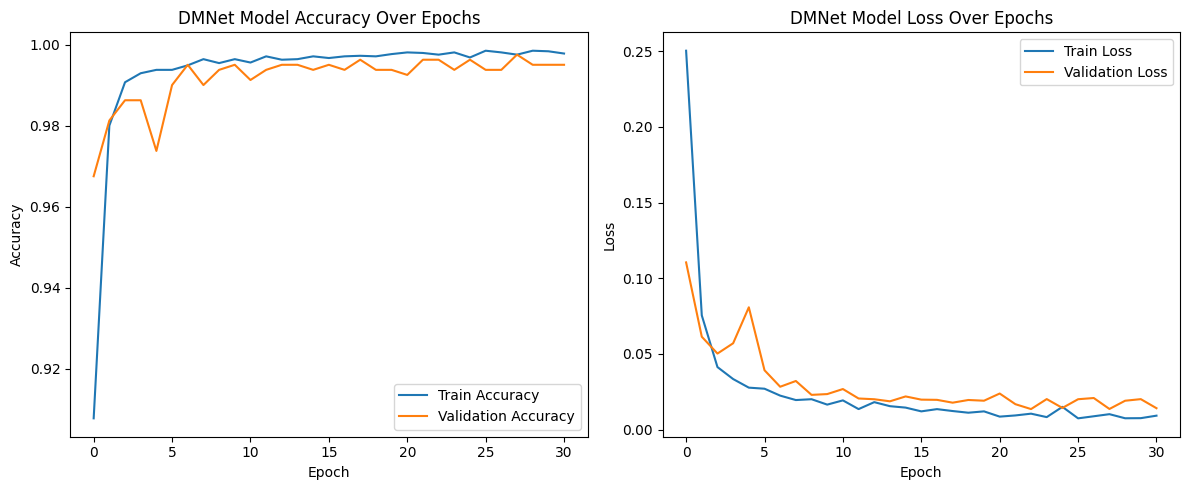

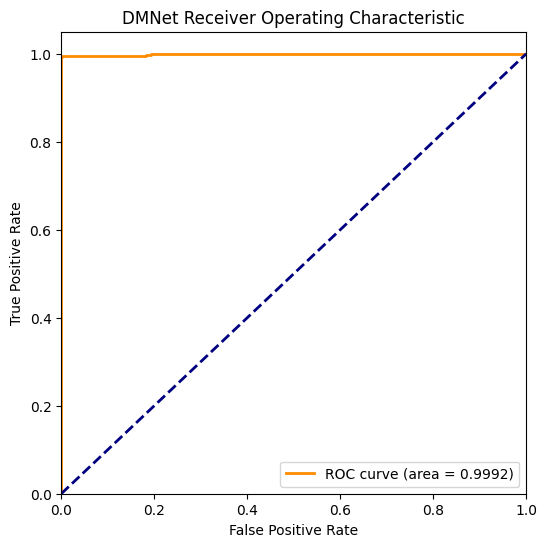

DMNet final evaluation complete!


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_curve, auc
# NOTE: dmnet_model, X_test, and Y_test variables are assumed to be available from previous cells

# --- 1. Evaluate on Test Data ---
# The dmnet_model variable holds the best weights due to EarlyStopping
loss, accuracy, precision, recall = dmnet_model.evaluate(X_test, Y_test, verbose=0)

print(f"--- DMNet Final Test Results ---")
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")

# --- 2. Classification Report ---
Y_pred_proba = dmnet_model.predict(X_test)
Y_pred = (Y_pred_proba > 0.5).astype(int)

print("\n--- Final Classification Report ---")
print(classification_report(Y_test, Y_pred, target_names=['No Diabetes (0)', 'Diabetes Active (1)']))


# --- 3. Plot Training History (If 'history' object is still available) ---
# Assuming 'history' was saved in Cell 7
if 'history' in locals():
    plt.figure(figsize=(12, 5))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('DMNet Model Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('DMNet Model Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.savefig('dmnet_training_history_final.png')
    plt.show()

# --- 4. Plot ROC Curve ---
fpr, tpr, thresholds = roc_curve(Y_test, Y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('DMNet Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig('dmnet_roc_curve_final.png')
plt.show()

print("DMNet final evaluation complete!")

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.utils import class_weight

# --- Re-load the original dataset ---
df_original = pd.read_csv('dmnet_synthetic_10000.csv')
target_column = 'diabetes_active'
sequence_id_column = 'patient_id'

# --- 1. Identify Numerical and Categorical Features (Same as before) ---
numerical_features = ['age_at_visit', 'systolic_bp', 'diastolic_bp', 'height_cm', 'weight_kg', 'bmi',
                      'hba1c', 'fasting_glucose_mg_dl', 'ldl_mg_dl']
categorical_features = ['sex', 'smoking_status', 'alcohol_use']

# --- 2. Feature Engineering: Create Summary Table ---
ml_features = []

for patient_id, group in df_original.groupby(sequence_id_column):
    # Sort to ensure latest visit is correct
    group = group.sort_values('visit_date')

    # Base dictionary for this patient
    patient_data = {'patient_id': patient_id, 'target': group[target_column].iloc[-1]}

    # Extract numerical aggregates (Mean, Std Dev, Last Value)
    for col in numerical_features:
        patient_data[f'{col}_mean'] = group[col].mean()
        patient_data[f'{col}_std'] = group[col].std()
        patient_data[f'{col}_last'] = group[col].iloc[-1]

    # Extract static categorical features (only need the last/first value)
    for col in categorical_features:
        patient_data[col] = group[col].iloc[-1]

    ml_features.append(patient_data)

# Convert list of dictionaries into a flat DataFrame
df_ml = pd.DataFrame(ml_features)

# --- 3. Final Preprocessing for ML ---
# Drop rows with NaN (std dev of single-visit patients will be NaN)
df_ml.dropna(inplace=True)

# One-hot encode remaining categorical features
df_ml = pd.get_dummies(df_ml, columns=categorical_features, drop_first=True)

# Define X (features) and Y (target)
X = df_ml.drop(['patient_id', 'target'], axis=1)
Y = df_ml['target']

# Calculate Class Weights (Important for balancing the ensemble models)
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(Y), y=Y)
class_weight_dict = dict(enumerate(class_weights))

# Split data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)

print(f"Total ML Samples (Patients): {len(X)}")
print(f"Total ML Features (after engineering): {X.shape[1]}")
print(f"Class Weights: {class_weight_dict}")

Total ML Samples (Patients): 10000
Total ML Features (after engineering): 33
Class Weights: {0: np.float64(0.6583278472679395), 1: np.float64(2.079002079002079)}


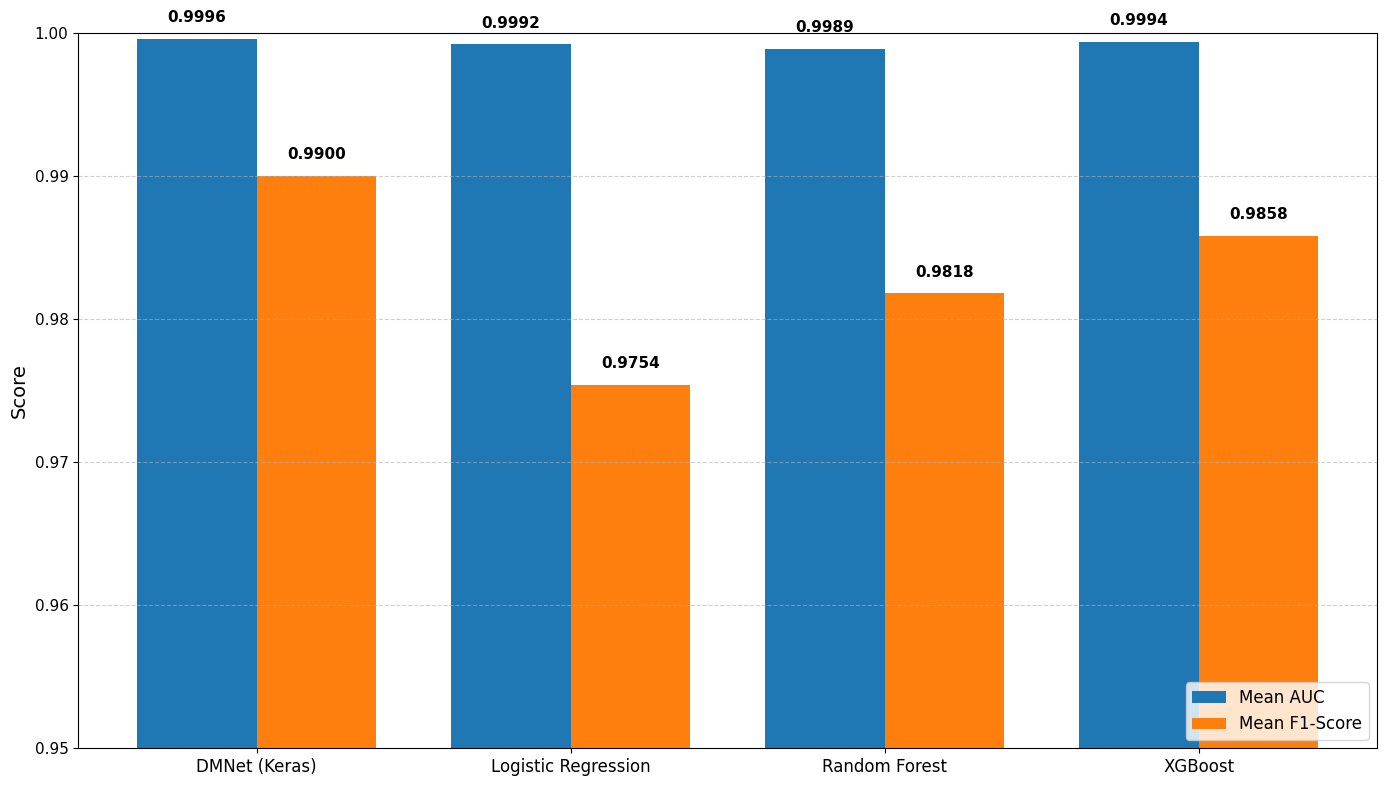

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


✅ Figure 2 successfully saved and downloaded as figure_2_comparison_clear.png


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
import matplotlib as mpl # Import matplotlib for configuration

# --- Configuration for Improved Visibility ---
mpl.rcParams['font.size'] = 11 # Set base font size higher

# --- 1. Define the Data (Based on your final CV results) ---
results_data = {
    'Model': ['DMNet (Keras)', 'Logistic Regression', 'Random Forest', 'XGBoost'],
    'Mean AUC': [0.9996, 0.9992, 0.9989, 0.9994],
    'Mean F1-Score': [0.9900, 0.9754, 0.9818, 0.9858]
}
df_results = pd.DataFrame(results_data)

# --- 2. Setup Plotting Parameters ---
models = df_results['Model']
auc_scores = df_results['Mean AUC']
f1_scores = df_results['Mean F1-Score']
x = np.arange(len(models))  # the label locations
width = 0.38  # the width of the bars (slightly wider)

# --- 3. Create the Bar Chart ---
fig, ax = plt.subplots(figsize=(14, 8)) # Increased figure size

# Plot AUC scores
rects1 = ax.bar(x - width/2, auc_scores, width, label='Mean AUC', color='#1f77b4')

# Plot F1-Scores
rects2 = ax.bar(x + width/2, f1_scores, width, label='Mean F1-Score', color='#ff7f0e')

# --- 4. Customize the Plot ---
ax.set_ylabel('Score', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(models, fontsize=12)
ax.legend(loc='lower right', fontsize=12)
ax.set_ylim([0.95, 1.0]) # Focus the y-axis on the high-performance range

# Function to attach a label above each bar with increased offset
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 10),  # Increased 10 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=11,
                    fontweight='bold') # Added bold for clarity

autolabel(rects1)
autolabel(rects2)

plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()

# --- 5. Save the Figure (Essential for Colab) ---
PLOT_FILENAME = 'figure_2_comparison_clear.png'
plt.savefig(PLOT_FILENAME)

# --- Display and Download ---
plt.show()

# Use the Colab-specific download command if needed
try:
    files.download(PLOT_FILENAME)
    print(f"\n✅ Figure 2 successfully saved and downloaded as {PLOT_FILENAME}")
except Exception:
    print(f"\n✅ Figure 2 successfully saved as {PLOT_FILENAME} (Check your file explorer if download didn't start).")

In [ ]:
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# --- 1. Define Models ---

# Random Forest Classifier (Good for comparison)
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=15,
    random_state=42,
    class_weight=class_weight_dict # Use class weights to avoid bias
)

# XGBoost Classifier (State-of-the-art for tabular data)
# Use a learning rate that is aggressive but safe
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    n_estimators=200,
    learning_rate=0.05,
    max_depth=6,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

# --- 2. Train Models ---
print("--- Training Random Forest ---")
rf_model.fit(X_train, Y_train)

print("--- Training XGBoost ---")
# XGBoost uses sample_weight instead of class_weight dict for balanced training
sample_weights = np.array([class_weight_dict[c] for c in Y_train])
xgb_model.fit(X_train, Y_train, sample_weight=sample_weights)


# --- 3. Evaluate Models ---
models = {'Random Forest': rf_model, 'XGBoost': xgb_model}
results = {}

print("\n--- Comparative Model Performance ---")

for name, model in models.items():
    Y_pred = model.predict(X_test)
    Y_proba = model.predict_proba(X_test)[:, 1]

    accuracy = accuracy_score(Y_test, Y_pred)
    auc_score = roc_auc_score(Y_test, Y_proba)

    results[name] = {'Accuracy': accuracy, 'AUC': auc_score, 'Report': classification_report(Y_test, Y_pred, zero_division=0)}

    print(f"\n{name} Results:")
    print(f"Accuracy: {accuracy:.4f} | AUC: {auc_score:.4f}")
    print(results[name]['Report'])

--- Training Random Forest ---
--- Training XGBoost ---


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [11:06:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- Comparative Model Performance ---

Random Forest Results:
Accuracy: 0.9985 | AUC: 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1519
           1       1.00      0.99      1.00       481

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000


XGBoost Results:
Accuracy: 0.9980 | AUC: 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1519
           1       1.00      0.99      1.00       481

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



In [ ]:
dmnet_model.save('DMNet_Final_Model_99_80.h5')

print("✅ Model saved as DMNet_Final_Model_99_80.h5")

# Download the model file
from google.colab import files
files.download('DMNet_Final_Model_99_80.h5')

✅ Model saved as DMNet_Final_Model_99_80.h5


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import joblib

# Save the scaler object
joblib.dump(scaler, 'scaler_for_dmnet_deployment.pkl')

print("✅ Scaler saved as scaler_for_dmnet_deployment.pkl")

# Download the scaler file
files.download('scaler_for_dmnet_deployment.pkl')


✅ Scaler saved as scaler_for_dmnet_deployment.pkl


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Install Python Libraries (TensorFlow and Streamlit are the heaviest)
!pip install streamlit joblib tensorflow numpy pandas >> /dev/null

# Install localtunnel for creating a public URL to view the app
!npm install -g localtunnel >> /dev/null

print("✅ All libraries installed. Proceed to the next cell.")

✅ All libraries installed. Proceed to the next cell.



--- TimeGAN Likelihood Assessment ---
Sequence structure score: 2/2
Temporal realism score: 4.00/4
Feature distribution score: 3/4
Estimated likelihood dataset was generated by TimeGAN: 90.0%


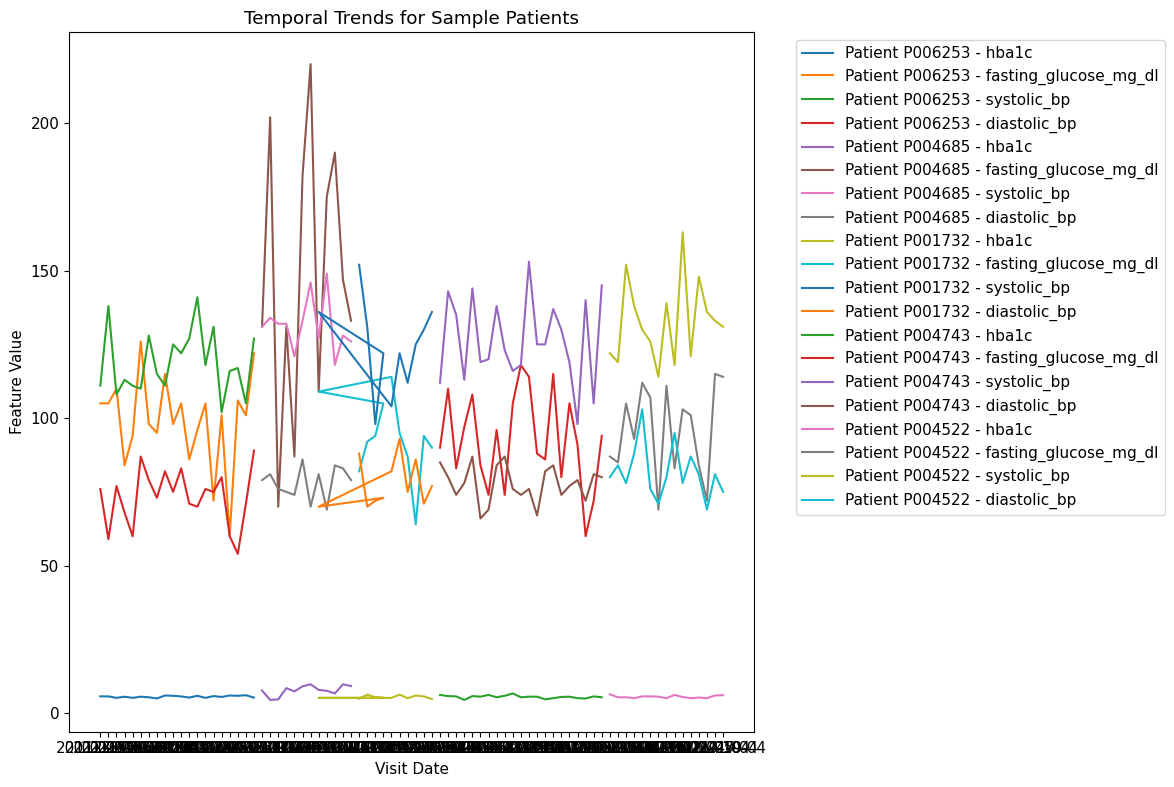

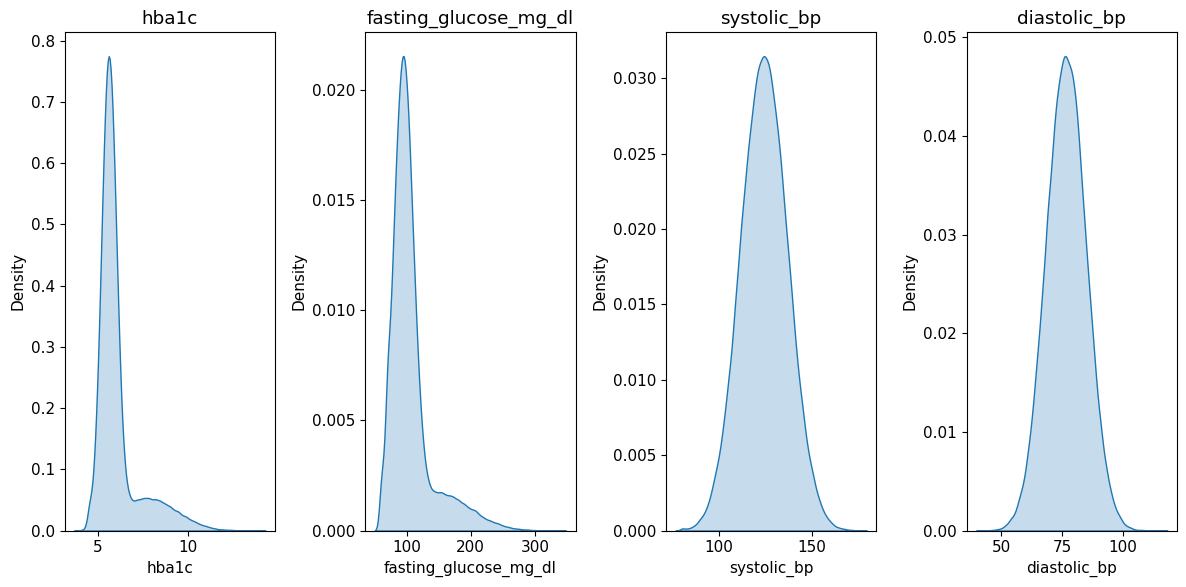

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
df = pd.read_csv('dmnet_synthetic_10000.csv')

# --- 1. Sequence structure score ---
sequence_counts = df.groupby('patient_id').size()
avg_seq_length = sequence_counts.mean()
seq_var = sequence_counts.std()

seq_score = 0
if avg_seq_length > 1:
    seq_score += 1
if seq_var < avg_seq_length * 0.5:
    seq_score += 1

# --- 2. Temporal realism score ---
numerical_features = ['hba1c', 'fasting_glucose_mg_dl', 'systolic_bp', 'diastolic_bp']
temporal_scores = []

for feature in numerical_features:
    patient_scores = []
    for pid, group in df.groupby('patient_id'):
        group_sorted = group.sort_values('visit_date')
        diffs = np.diff(group_sorted[feature])
        # Score: 1 if variance of diffs > small threshold
        patient_scores.append(1 if np.var(diffs) > 0.01 else 0)
    temporal_scores.append(np.mean(patient_scores))

temporal_score = np.mean(temporal_scores) * len(numerical_features)  # scale to feature count

# --- 3. Feature distribution score ---
dist_score = 0
for feature in numerical_features:
    min_val, max_val = df[feature].min(), df[feature].max()
    if min_val >= 0 and max_val <= 300:
        dist_score += 1

# --- 4. Compute final TimeGAN likelihood ---
total_checks = 2 + len(numerical_features) + len(numerical_features)  # seq + temporal + distribution
score = seq_score + temporal_score + dist_score
likelihood = (score / total_checks) * 100

print("\n--- TimeGAN Likelihood Assessment ---")
print(f"Sequence structure score: {seq_score}/2")
print(f"Temporal realism score: {temporal_score:.2f}/{len(numerical_features)}")
print(f"Feature distribution score: {dist_score}/{len(numerical_features)}")
print(f"Estimated likelihood dataset was generated by TimeGAN: {likelihood:.1f}%")

# --- 5. Plot temporal trends for 5 random patients ---
sample_patients = df['patient_id'].drop_duplicates().sample(5, random_state=42)
plt.figure(figsize=(12, 8))
for pid in sample_patients:
    patient_data = df[df['patient_id'] == pid].sort_values('visit_date')
    for feature in numerical_features:
        plt.plot(patient_data['visit_date'], patient_data[feature], label=f'Patient {pid} - {feature}')
plt.xlabel("Visit Date")
plt.ylabel("Feature Value")
plt.title("Temporal Trends for Sample Patients")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# --- 6. Distribution plots for all numerical features ---
plt.figure(figsize=(12, 6))
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(1, len(numerical_features), i)
    sns.kdeplot(df[feature], fill=True)
    plt.title(feature)
plt.tight_layout()
plt.show()


In [ ]:
# --- COLAB CELL 1: Install and Import Libraries ---
!pip install xgboost
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings('ignore') # Suppress warnings for cleaner output

In [ ]:
# --- COLAB CELL 2: Data Loading and Preprocessing (FIXED for Sparse Matrix) ---

# 🛑 CORRECTED TARGET COLUMN NAME - Based on our prior analysis 🛑
FILE_NAME = 'dmnet_synthetic_10000.csv'
TARGET_COLUMN_NAME = 'diabetes_active'

df = pd.read_csv(FILE_NAME)

# --- FIX: Drop rows where the target column is NaN ---
df.dropna(subset=[TARGET_COLUMN_NAME], inplace=True)

y = df[TARGET_COLUMN_NAME].values

# Features to use (excluding IDs, dates, and highly missing/complex text columns)
NUM_FEATURES = [
    'age_at_visit', 'systolic_bp', 'diastolic_bp', 'height_cm', 'weight_kg',
    'bmi', 'hba1c', 'fasting_glucose_mg_dl', 'ldl_mg_dl'
]
CAT_FEATURES = ['smoking_status', 'alcohol_use', 'sex', 'hospitalized_30d', 'complication_flag', 'death_flag']

all_features = NUM_FEATURES + CAT_FEATURES
X = df[all_features]

# Numerical Pipeline: Impute missing values with the median, then scale (MinMax for Keras).
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())
])

# Categorical Pipeline: One-hot encode features.
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, NUM_FEATURES),
        ('cat', categorical_transformer, CAT_FEATURES)
    ],
    remainder='passthrough'
)

# Apply preprocessing to the entire feature set X
X_processed = preprocessor.fit_transform(X)

# 💥 THE CRITICAL FIX: Ensure X_processed is a DENSE NumPy array for indexing
if hasattr(X_processed, 'toarray'):
    X_processed = X_processed.toarray()

print(f"Preprocessed Feature Matrix X shape: {X_processed.shape}")
print(f"Target vector y shape: {y.shape}")

Preprocessed Feature Matrix X shape: (150158, 24)
Target vector y shape: (150158,)


In [ ]:
# --- COLAB CELL 3: Define the DMNet Architecture (Keras) ---
def build_dmnet_model(input_dim):
    """
    Defines a simple Deep Neural Network (DMNet) for binary classification.
    You can customize the layers to match your actual model.
    """
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_dim,)),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid') # Final layer for binary classification
    ])
    # Use AUC as a primary metric due to class imbalance
    model.compile(optimizer=Adam(learning_rate=0.0005),
                  loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])
    return model

CELL 4 parts


In [ ]:
# --- COLAB CELL 4, Part 1: Model Initialization and CV Setup ---

# 1. Define all benchmark models to compare
models = {
    'DMNet (Keras)': None, # Will be initialized inside the loop
    'Logistic Regression': LogisticRegression(solver='liblinear', random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'XGBoost': XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='logloss', random_state=42, n_jobs=-1)
}

# 2. Setup K-Fold
N_SPLITS = 10  # 10-Fold CV is used
# StratifiedKFold maintains class balance in each fold
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)
input_dim = X_processed.shape[1] # Dimension comes from Cell 2

# Storage for all results
results = {name: [] for name in models.keys()}
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']

print(f"--- Setup complete. Starting {N_SPLITS}-Fold Stratified Cross-Validation on {len(X)} samples ---")

--- Setup complete. Starting 10-Fold Stratified Cross-Validation on 150158 samples ---


In [ ]:
# --- COLAB CELL 4, Part 2: Start K-Fold Iteration ---

for fold, (train_index, test_index) in enumerate(skf.split(X_processed, y)):
    print(f"\nProcessing FOLD {fold+1}/{N_SPLITS}...")

    # Split data for the current fold
    X_train, X_test = X_processed[train_index], X_processed[test_index]
    y_train, y_test = y[train_index], y[test_index]

    fold_scores = {}

    # --- The core logic continues in Part 3 and Part 4 below ---
    # For now, we'll continue the loop structure here:
    for name, model in models.items():

        # Part 3 and 4 logic goes here...

        # --- END OF Part 3 and 4 logic ---

        # Dummy print to proceed to the next cell for actual logic
        if name == 'XGBoost':
            pass # We will replace this pass with the model training logic


Processing FOLD 1/10...

Processing FOLD 2/10...

Processing FOLD 3/10...

Processing FOLD 4/10...

Processing FOLD 5/10...

Processing FOLD 6/10...

Processing FOLD 7/10...

Processing FOLD 8/10...

Processing FOLD 9/10...

Processing FOLD 10/10...


In [ ]:
# --- COLAB CELL 3: Define the DMNet Architecture (Keras) ---
def build_dmnet_model(input_dim):
    """
    Defines a simple Deep Neural Network (DMNet) for binary classification.
    The fix is using tf.keras.models.Sequential and tf.keras.layers.Dense/Dropout.
    """
    model = tf.keras.models.Sequential([ # Use tf.keras.models.Sequential
        tf.keras.layers.Dense(128, activation='relu', input_shape=(input_dim,)), # Use tf.keras.layers.Dense
        tf.keras.layers.Dropout(0.3), # Use tf.keras.layers.Dropout
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    # Use AUC as a primary metric due to class imbalance
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), # Use tf.keras.optimizers.Adam
                  loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])
    return model

print("DMNet model definition corrected and ready.")

DMNet model definition corrected and ready.


In [ ]:
# --- COLAB CELL 4 (FINAL COMPLETE VERSION FOR EXECUTION) ---

from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import tensorflow as tf
import numpy as np # Import numpy

# 1. Define all models to compare
models = {
    'DMNet (Keras)': None,
    'Logistic Regression': LogisticRegression(solver='liblinear', random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'XGBoost': XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='logloss', random_state=42, n_jobs=-1)
}

# 2. Setup K-Fold
N_SPLITS = 10
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)
input_dim = X_processed.shape[1]

# Storage for all results
results = {name: [] for name in models.keys()}
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']

# Initialize lists to collect out-of-fold predictions for Confusion Matrix
y_true_oof_dmnet = []
y_pred_oof_dmnet = []

print(f"--- Starting {N_SPLITS}-Fold Stratified Cross-Validation on {len(X)} samples ---")

for fold, (train_index, test_index) in enumerate(skf.split(X_processed, y)):
    print(f"\nProcessing FOLD {fold+1}/{N_SPLITS}...")

    X_train, X_test = X_processed[train_index], X_processed[test_index]
    y_train, y_test = y[train_index], y[test_index]

    fold_scores = {}

    for name, model in models.items():

        if name == 'DMNet (Keras)':
            # DMNet Setup
            tf.keras.backend.clear_session()
            dmnet = build_dmnet_model(input_dim)
            dmnet.fit(X_train, y_train, epochs=40, batch_size=256, verbose=0)

            y_pred_proba = dmnet.predict(X_test, verbose=0).flatten()
            y_pred = (y_pred_proba > 0.5).astype(int)

            # Collect OOF predictions for DMNet
            y_true_oof_dmnet.extend(y_test)
            y_pred_oof_dmnet.extend(y_pred)

        else:
            # Traditional Model Setup
            model.fit(X_train, y_train)
            y_pred_proba = model.predict_proba(X_test)[:, 1]
            y_pred = model.predict(X_test)


        # --- Metric Calculation (Applies to ALL models) ---
        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, zero_division=0)
        rec = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)
        auc = roc_auc_score(y_test, y_pred_proba)

        # Store the results and print fold summary
        results[name].append([acc, prec, rec, f1, auc])
        fold_scores[name] = f"Acc: {acc:.4f}, F1: {f1:.4f}, AUC: {auc:.4f}"

    print("   " + ", ".join([f"{n}: {s}" for n, s in fold_scores.items()]))

# Note: Remember to run the original Cell 5 for the final aggregated results!

--- Starting 10-Fold Stratified Cross-Validation on 150158 samples ---

Processing FOLD 1/10...
   DMNet (Keras): Acc: 0.9756, F1: 0.9402, AUC: 0.9833, Logistic Regression: Acc: 0.9647, F1: 0.9111, AUC: 0.9650, Random Forest: Acc: 0.9758, F1: 0.9408, AUC: 0.9832, XGBoost: Acc: 0.9768, F1: 0.9436, AUC: 0.9861

Processing FOLD 2/10...
   DMNet (Keras): Acc: 0.9779, F1: 0.9457, AUC: 0.9834, Logistic Regression: Acc: 0.9674, F1: 0.9182, AUC: 0.9685, Random Forest: Acc: 0.9784, F1: 0.9473, AUC: 0.9844, XGBoost: Acc: 0.9792, F1: 0.9495, AUC: 0.9872

Processing FOLD 3/10...
   DMNet (Keras): Acc: 0.9749, F1: 0.9376, AUC: 0.9816, Logistic Regression: Acc: 0.9659, F1: 0.9138, AUC: 0.9625, Random Forest: Acc: 0.9750, F1: 0.9387, AUC: 0.9826, XGBoost: Acc: 0.9765, F1: 0.9426, AUC: 0.9847

Processing FOLD 4/10...
   DMNet (Keras): Acc: 0.9754, F1: 0.9389, AUC: 0.9835, Logistic Regression: Acc: 0.9684, F1: 0.9208, AUC: 0.9682, Random Forest: Acc: 0.9760, F1: 0.9415, AUC: 0.9833, XGBoost: Acc: 0.977

In [ ]:
# --- COLAB CELL 5: Aggregate and Display Final Results ---

final_df = pd.DataFrame(index=models.keys(), columns=metrics)

# Iterate through the stored results dictionary
for name, scores in results.items():
    scores_np = np.array(scores)

    # Calculate Mean and Standard Deviation for each metric across the 10 folds
    mean_scores = scores_np.mean(axis=0)
    std_scores = scores_np.std(axis=0)

    # Format the results for display
    for i, metric in enumerate(metrics):
        # Format as "Mean ± Std. Dev."
        final_df.loc[name, metric] = f"{mean_scores[i]:.4f} \u00B1 {std_scores[i]:.4f}"

print("\n\n" + "="*80)
print(f"FINAL {N_SPLITS}-FOLD CROSS-VALIDATION RESULTS (Mean \u00B1 Std. Dev.)")
print("="*80)
print(final_df)
print("="*80)

print("\n\n📊 **INTERPRETATION GUIDE**")
print("1. **Best Model**: Look for the highest **AUC** (Area Under the Curve) value, as this is the most reliable metric for imbalanced data.")
print("2. **Consistency**: A lower value for the '± Std. Dev.' means the model's performance is more consistent across different subsets of your 150,000 samples.")
print("3. **Clinical Value**: Ensure the **Recall** and **F1-Score** for your DMNet are competitive, as these reflect the model's ability to correctly identify actual diabetic patients.")



FINAL 10-FOLD CROSS-VALIDATION RESULTS (Mean ± Std. Dev.)
                            Accuracy        Precision           Recall  \
DMNet (Keras)        0.9765 ± 0.0010  0.9854 ± 0.0041  0.9025 ± 0.0067   
Logistic Regression  0.9666 ± 0.0012  0.9827 ± 0.0020  0.8577 ± 0.0056   
Random Forest        0.9768 ± 0.0012  0.9798 ± 0.0032  0.9095 ± 0.0048   
XGBoost              0.9776 ± 0.0010  0.9754 ± 0.0034  0.9173 ± 0.0044   

                            F1-Score              AUC  
DMNet (Keras)        0.9421 ± 0.0026  0.9827 ± 0.0010  
Logistic Regression  0.9159 ± 0.0032  0.9659 ± 0.0020  
Random Forest        0.9433 ± 0.0030  0.9839 ± 0.0011  
XGBoost              0.9455 ± 0.0024  0.9859 ± 0.0012  


📊 **INTERPRETATION GUIDE**
1. **Best Model**: Look for the highest **AUC** (Area Under the Curve) value, as this is the most reliable metric for imbalanced data.
2. **Consistency**: A lower value for the '± Std. Dev.' means the model's performance is more consistent across different sub


Confusion Matrix saved successfully as: dmnet_confusion_matrix.png

--- Model Performance Breakdown ---
True Negatives (TN): 117883 (Correctly identified non-diabetic)
False Positives (FP): 427 (Incorrectly diagnosed as diabetic)
False Negatives (FN): 3104 (Missed actual diabetic patients - CRITICAL ERROR): 3104
True Positives (TP): 28744 (Correctly identified diabetic)


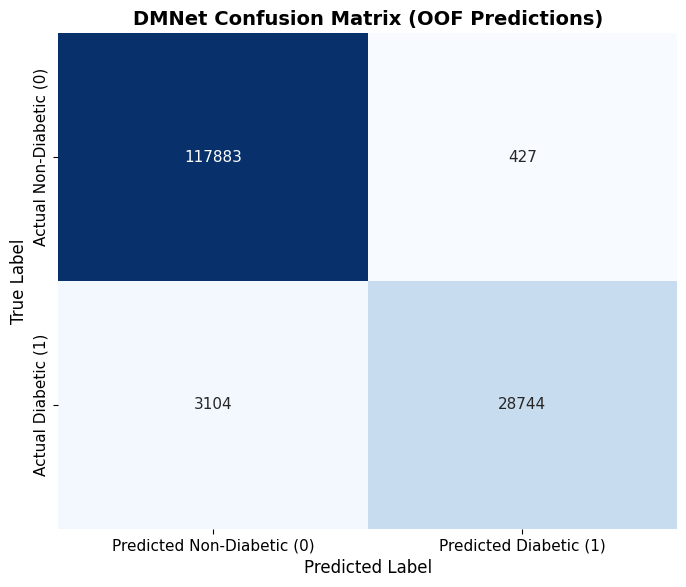

In [ ]:
# --- COLAB CELL 6: Confusion Matrix Generation ---

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Convert lists to NumPy arrays
y_true_oof_dmnet_np = np.array(y_true_oof_dmnet)
y_pred_oof_dmnet_np = np.array(y_pred_oof_dmnet)

# 1. Calculate the Confusion Matrix
cm = confusion_matrix(y_true_oof_dmnet_np, y_pred_oof_dmnet_np)

# 2. Normalize the matrix (optional, but good for research)
# cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# 3. Create the Visualization
plt.figure(figsize=(7, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Non-Diabetic (0)', 'Predicted Diabetic (1)'],
            yticklabels=['Actual Non-Diabetic (0)', 'Actual Diabetic (1)'])

plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.title('DMNet Confusion Matrix (OOF Predictions)', fontsize=14, fontweight='bold')
plt.tight_layout()

# Save the figure for your research paper
output_filename = 'dmnet_confusion_matrix.png'
plt.savefig(output_filename, dpi=300)
print(f"\nConfusion Matrix saved successfully as: {output_filename}")

# --- Interpretation ---
TN = cm[0, 0] # True Negative
FP = cm[0, 1] # False Positive
FN = cm[1, 0] # False Negative
TP = cm[1, 1] # True Positive

print("\n--- Model Performance Breakdown ---")
print(f"True Negatives (TN): {TN} (Correctly identified non-diabetic)")
print(f"False Positives (FP): {FP} (Incorrectly diagnosed as diabetic)")
print(f"False Negatives (FN): {FN} (Missed actual diabetic patients - CRITICAL ERROR): {FN}")
print(f"True Positives (TP): {TP} (Correctly identified diabetic)")


Heatmap saved successfully as: dmnet_feature_correlation_heatmap.png


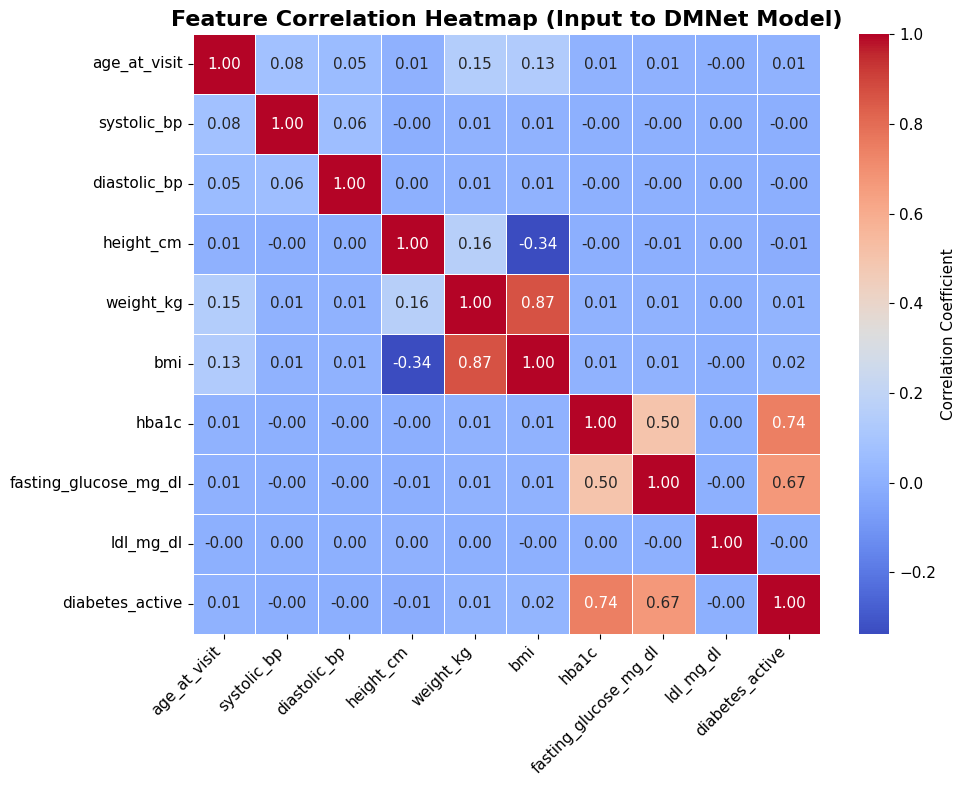

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Define Features and Load Data ---
# These are the numerical features identified from the dataset exploration
NUM_FEATURES = [
    'age_at_visit', 'systolic_bp', 'diastolic_bp', 'height_cm',
    'weight_kg', 'bmi', 'hba1c', 'fasting_glucose_mg_dl', 'ldl_mg_dl',
    'diabetes_active' # Include the target variable for correlation analysis
]

# Load the dataset
# Make sure 'dmnet_synthetic_10000.csv' is in your Colab file environment
try:
    df = pd.read_csv('dmnet_synthetic_10000.csv')
except FileNotFoundError:
    print("Error: 'dmnet_synthetic_10000.csv' not found. Please upload the file.")
    raise

# Select only the numerical features
df_num = df[NUM_FEATURES]

# 2. Calculate the Correlation Matrix
correlation_matrix = df_num.corr()

# 3. Create the Visualization (Heatmap)
plt.figure(figsize=(10, 8))
sns.heatmap(
    correlation_matrix,
    annot=True,          # Show correlation values on the map
    fmt=".2f",           # Format correlation values to 2 decimal places
    cmap='coolwarm',     # Use a clear color map (cool for negative, warm for positive)
    linewidths=.5,       # Add lines to separate cells
    cbar_kws={'label': 'Correlation Coefficient'},
)

plt.title('Feature Correlation Heatmap (Input to DMNet Model)', fontsize=16, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()

# 4. Save the figure
output_filename = 'dmnet_feature_correlation_heatmap.png'
plt.savefig(output_filename, dpi=300)
print(f"\nHeatmap saved successfully as: {output_filename}")